## Stylize Your Images In 5 Minutes

Demo developed by [Sayak Paul](https://twitter.com/RisingSayak).

Neural style transfer is one of the most interesting applications of deep learning. We've created a demo to help you recreate your images in the style of famous artists. 

![](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

The image and code id adapted from [this tutorial](https://www.tensorflow.org/lite/models/style_transfer/overview). 

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2 as cv
from functools import cache

In [12]:
style_image_path = "./style.png"
content_image_path = "./temp.png"

You can upload as many images as you would want to but we will only pick the last uploaded one. 

In [13]:
# Load the images
# Function to load an image from a file, and add a batch dimension.
def load_img_opencv(img_path):
    img = cv.imread(img_path)
    img = np.float32(img)/255.0
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = tf.convert_to_tensor(img)
    img = img[tf.newaxis, :]
    return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

Images loaded up!


In [15]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path='predict.tflite')

  preprocessed_style_image = preprocess_image(style_image, 256)
  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck


# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, content_image, content_image_size=512):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path='transfer.tflite')

  preprocessed_content_image = preprocess_image(content_image, content_image_size)

  # Set model input.
  input_details = interpreter.get_input_details()
  for index in range(len(input_details)):
    if input_details[index]["name"]=='content_image':
      index = input_details[index]["index"]
      interpreter.resize_tensor_input(index, [1, content_image_size, content_image_size, 3])
  interpreter.allocate_tensors()

  # Set model inputs.
  for index in range(len(input_details)):
    if input_details[index]["name"]=='Conv/BiasAdd':
      interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
    elif input_details[index]["name"]=='content_image':
      interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return tf.image.resize(stylized_image[0], content_image[0].shape[:-1], antialias=True)



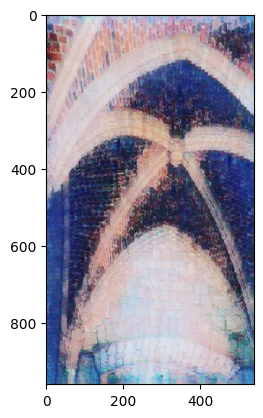

In [17]:
# Load the input images.
content_image = load_img_opencv("./temp.png")
style_image = load_img_opencv("./style.png")

# Preprocess the input images.
style_bottleneck = run_style_predict(style_image)
stylized_image = run_style_transform(style_bottleneck, content_image)

# Visualize the output.
plt.imshow(stylized_image.numpy())